In [28]:
import requests
import pandas as pd
from IPython.display import display, HTML

# Set pandas options for better display
pd.set_option('display.max_columns', None)  # Shows all columns
pd.set_option('display.max_rows', None)  # Shows all rows
pd.set_option('display.max_colwidth', None)  # Shows full content of each column
pd.set_option('display.width', None)  # Auto-detects the display width

# API URL
url = "https://api.data.gov.in/resource/a6937ac4-490e-45d0-9b2f-d562c09c9f13?api-key=579b464db66ec23bdd000001cdd3946e44ce4aad7209ff7b23ac571b&format=csv"

# Fetch the data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load data into DataFrame
    data = pd.read_csv(url)
    
    # Print the column names
    print("Column names:", data.columns.tolist())
    
    # Display the DataFrame as an HTML table using HTML from IPython.display
    display(HTML(data.to_html()))

    # Save the DataFrame to a CSV file
    data.to_csv('data.csv', index=False)
    print('Data saved to data.csv.')
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")




Column names: ['GROUP', 'PRODUCT', '2009-2010 QTY', '2009-2010 VAL', '2010-2011 QTY', '2010-2011 VAL', '2011-2012 QTY', '2011-2012 VAL', '2012-2013 QTY', '2012-2013 VAL', '2013-2014 QTY', '2013-2014 VAL', '2014-2015 QTY', '2014-2015  VAL', '2015-2016 QTY ', '2015-2016  VAL|', '2016-2017 upto Sept.16 QTY ', '2016-2017 upto Sept.16 VAL']


,GROUP,PRODUCT,2009-2010 QTY,2009-2010 VAL,2010-2011 QTY,2010-2011 VAL,2011-2012 QTY,2011-2012 VAL,2012-2013 QTY,2012-2013 VAL,2013-2014 QTY,2013-2014 VAL,2014-2015 QTY,2014-2015 VAL,2015-2016 QTY,2015-2016 VAL|,2016-2017 upto Sept.16 QTY,2016-2017 upto Sept.16 VAL
0,SYNTHETIC FIBRES,ACRYLIC FIBRE,14568,16723,23611,33365,20200,27538,29359,42077,32990,53051,36339,60959,39238,53809,23007,26813
1,SYNTHETIC FIBRES,NYLON FILAMENT YARN,6624,10886,18138,31224,22907,45227,24067,52783,24295,54650,27813,59448,28972,54485,15267,25067
2,SYNTHETIC FIBRES,NYLON INDUSTRIAL YARN/TYRE CORD,10789,14581,12269,18388,9068,16629,11912,21275,7022,13749,3750,7035,4411,6803,4687,6042
3,SYNTHETIC FIBRES,POLYESTER FILAMENT YARN,50095,43944,33692,36053,43409,52693,50013,64792,46713,67653,72718,89105,72605,86166,47203,51022
4,SYNTHETIC FIBRES,POLYESTER STAPLE FIBRE,14417,10040,31549,23070,44677,36811,29670,27653,42635,41577,81864,71552,99719,73357,44042,31196
5,SYNTHETIC FIBRES,POLYPROPYLENE FILAMENT YARN,1214,1283,1489,1827,1899,2396,1598,2673,792,1056,716,1002,697,1001,436,516
6,SYNTHETIC FIBRES,POLYPROPYLENE STAPLE FIBRE,153,168,122,160,336,441,331,495,401,567,329,461,1885,1997,601,716
7,FIBRE INTERMEDIATES,ACRYLONITRILE,64693,42104,72618,73592,77357,77714,81964,83719,100862,111632,97388,118956,160202,121692,77980,53708
8,FIBRE INTERMEDIATES,CAPROLACTUM,11292,8933,6334,8158,5381,9121,15917,21673,23494,34307,32276,43571,44577,45299,28516,24860
9,FIBRE INTERMEDIATES,DIMETHYL TEREPHTHALATE,4171,1906,4428,2554,2815,2021,2104,1592,1786,1466,2094,1594,2216,1400,828,475


Data saved to data.csv.


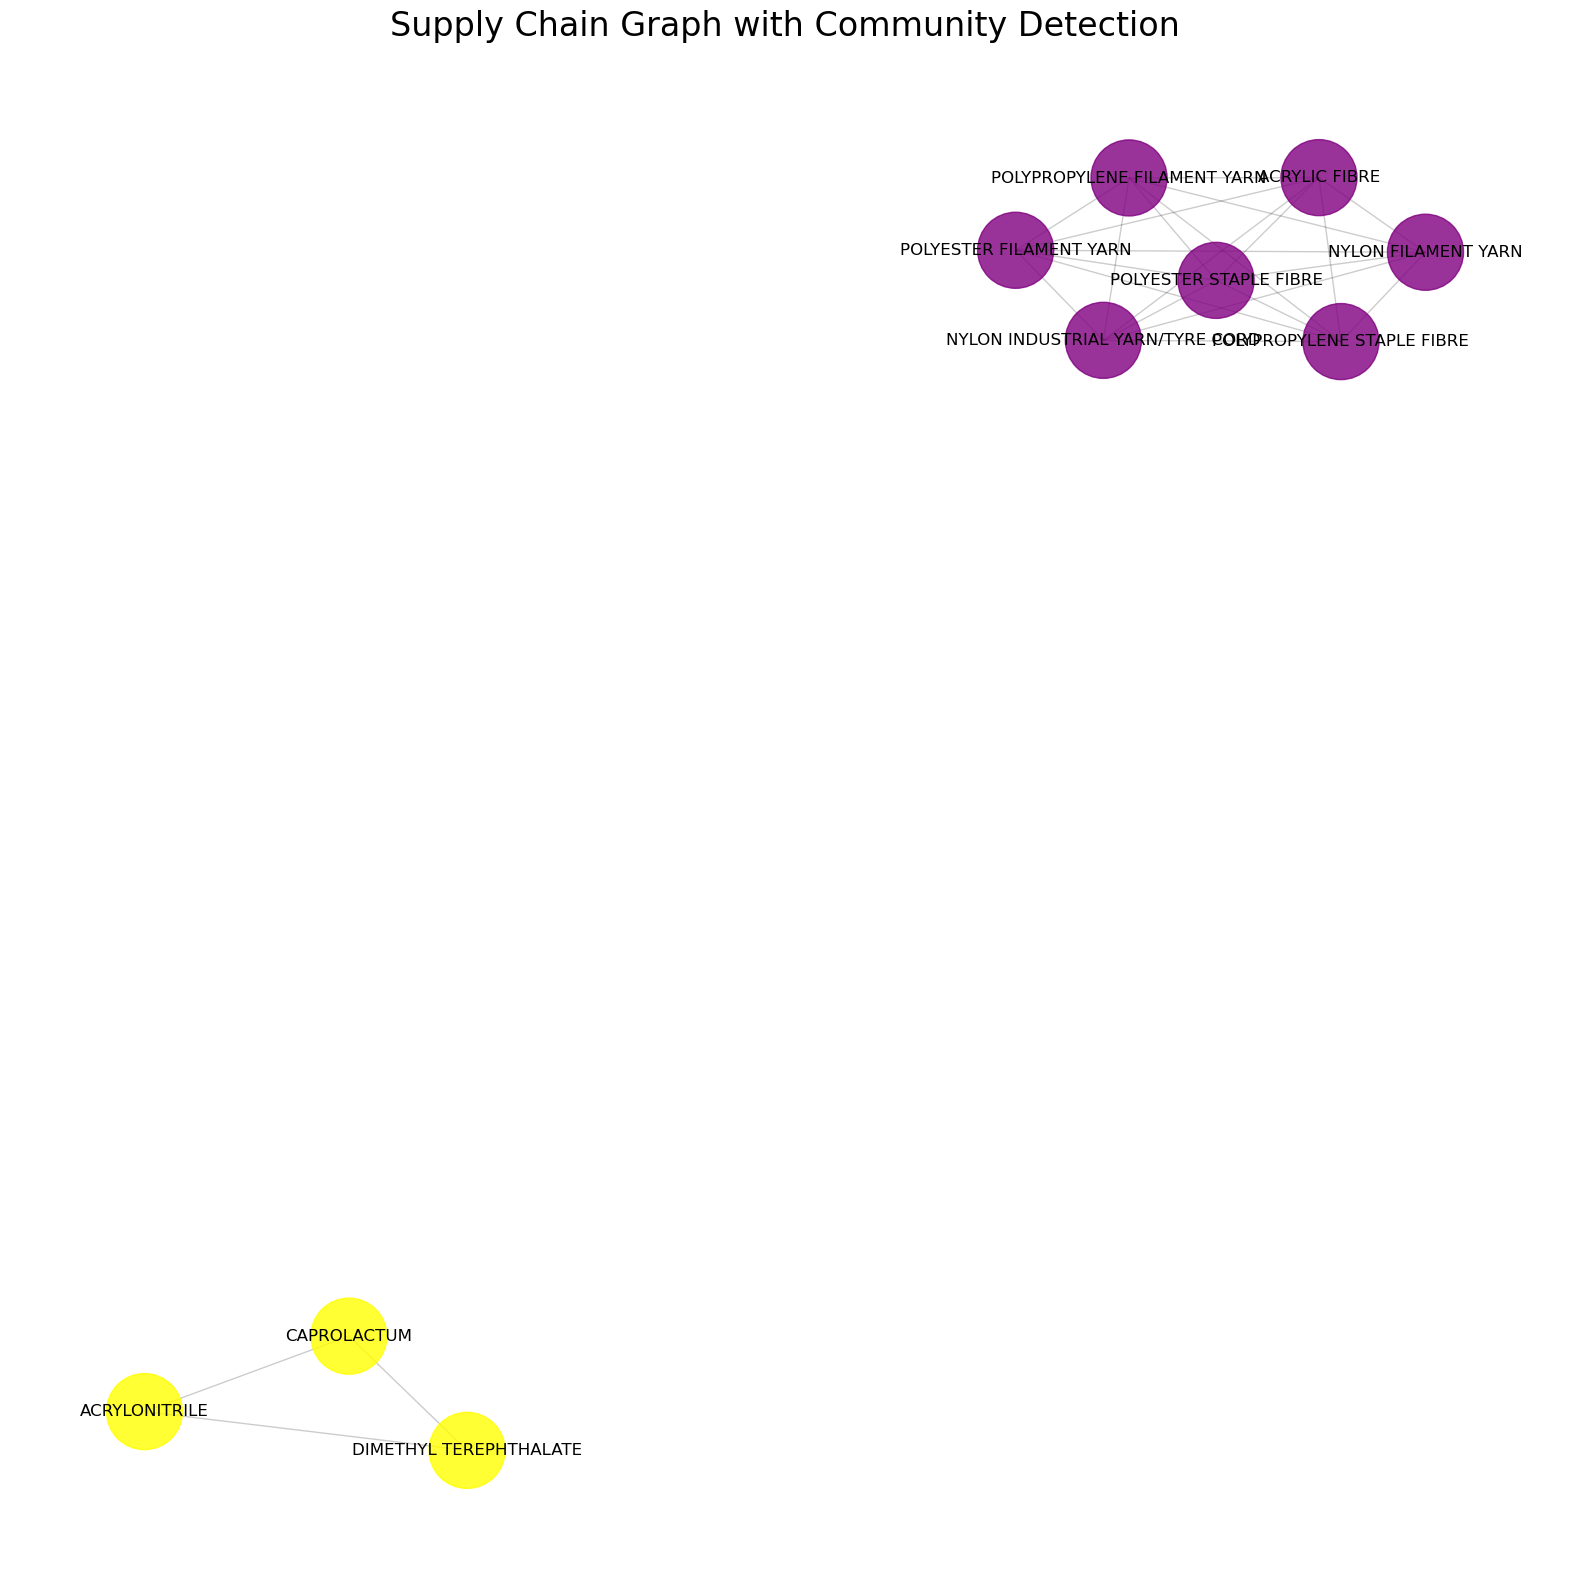

In [29]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

# Assuming 'data' is your DataFrame loaded previously

# Create a graph
G = nx.Graph()

# Add nodes with their respective features (quantities and values)
for index, row in data.iterrows():
    G.add_node(row['PRODUCT'], group=row['GROUP'])

# Add edges between nodes of the same group
for i, row_i in data.iterrows():
    for j, row_j in data.iterrows():
        if i != j and row_i['GROUP'] == row_j['GROUP']:
            G.add_edge(row_i['PRODUCT'], row_j['PRODUCT'])

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G)

# Generate initial layout for the graph
pos = nx.spring_layout(G, seed=42)

# Set the desired figure size and aspect ratio
plt.figure(figsize=(20, 20))

# Assign different colors to nodes based on community membership
node_color = ['yellow' if partition[node] == 0 else 'purple' for node in G.nodes()]

# Draw nodes, edges, and labels for the graph
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.8, node_size=3000)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Add title
plt.title('Supply Chain Graph with Community Detection', fontsize=24)

# Display the graph
plt.axis('off')
plt.show()



In [30]:
import pandas as pd
import networkx as nx
import numpy as np

# Assuming 'data' is your DataFrame

# Correlation Graph
G_corr = nx.Graph()

# Add nodes
for product in data['PRODUCT'].unique():
    G_corr.add_node(product)

# Calculate correlations and add edges
qty_cols = [col for col in data.columns if 'QTY' in col]
for i, product1 in enumerate(data['PRODUCT'].unique()):
    for j, product2 in enumerate(data['PRODUCT'].unique()):
        if i < j:
            # Extract quantities over the years for both products
            qty1 = data[data['PRODUCT'] == product1][qty_cols].iloc[0]
            qty2 = data[data['PRODUCT'] == product2][qty_cols].iloc[0]
            correlation = np.corrcoef(qty1, qty2)[0, 1]
            if abs(correlation) > 0.5:  # Threshold for significant correlation
                G_corr.add_edge(product1, product2, weight=correlation)

# Bipartite Graph
G_bipartite = nx.Graph()

# Add product nodes and year nodes
for product in data['PRODUCT'].unique():
    G_bipartite.add_node(product, bipartite=0)
for year in qty_cols:
    G_bipartite.add_node(year, bipartite=1)

# Add edges
for index, row in data.iterrows():
    for year in qty_cols:
        qty = row[year]
        # Here, we use quantity as the edge attribute; similarly, you could add value
        G_bipartite.add_edge(row['PRODUCT'], year, quantity=qty)

# Visualization and further analysis steps would follow here



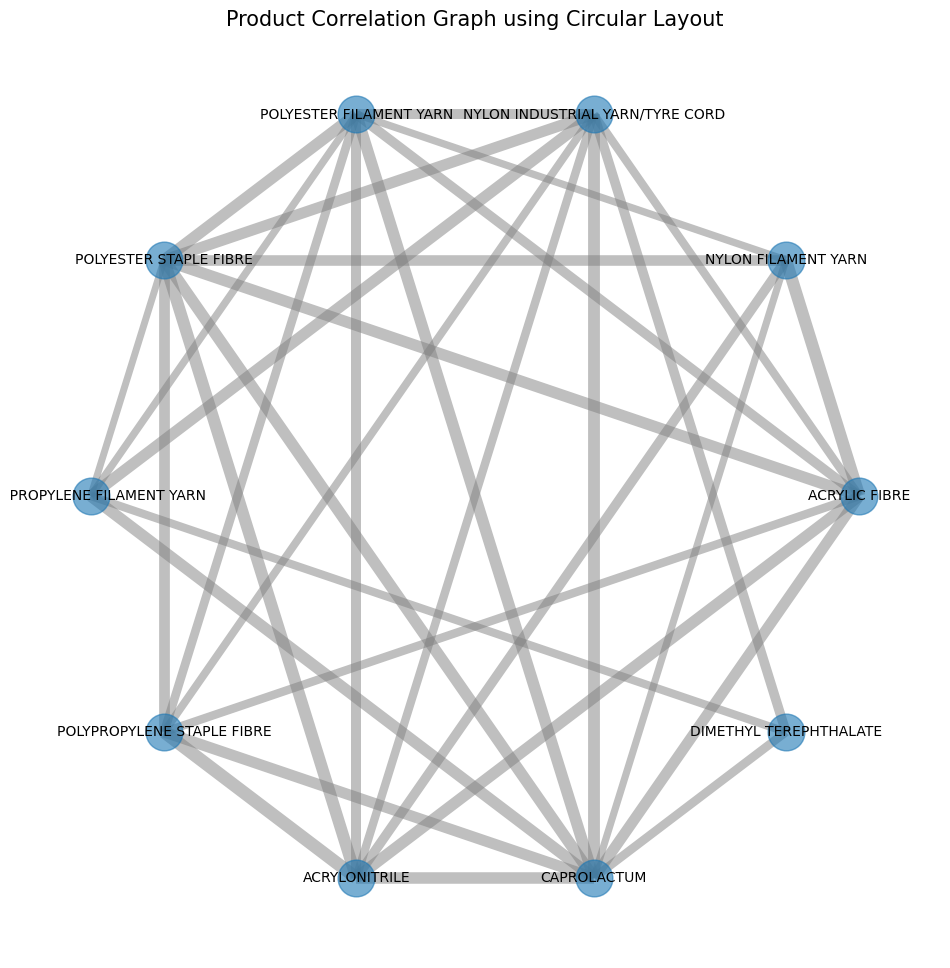

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# Use circular layout for positioning
pos = nx.circular_layout(G_corr)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_corr, pos, node_size=700, alpha=0.6)
nx.draw_networkx_labels(G_corr, pos, font_size=10)
edge_weights = [abs(G_corr[u][v]['weight'])*10 for u,v in G_corr.edges()]
nx.draw_networkx_edges(G_corr, pos, width=edge_weights, alpha=0.5, edge_color="grey")
plt.title("Product Correlation Graph using Circular Layout", size=15)
plt.axis('off')
plt.show()



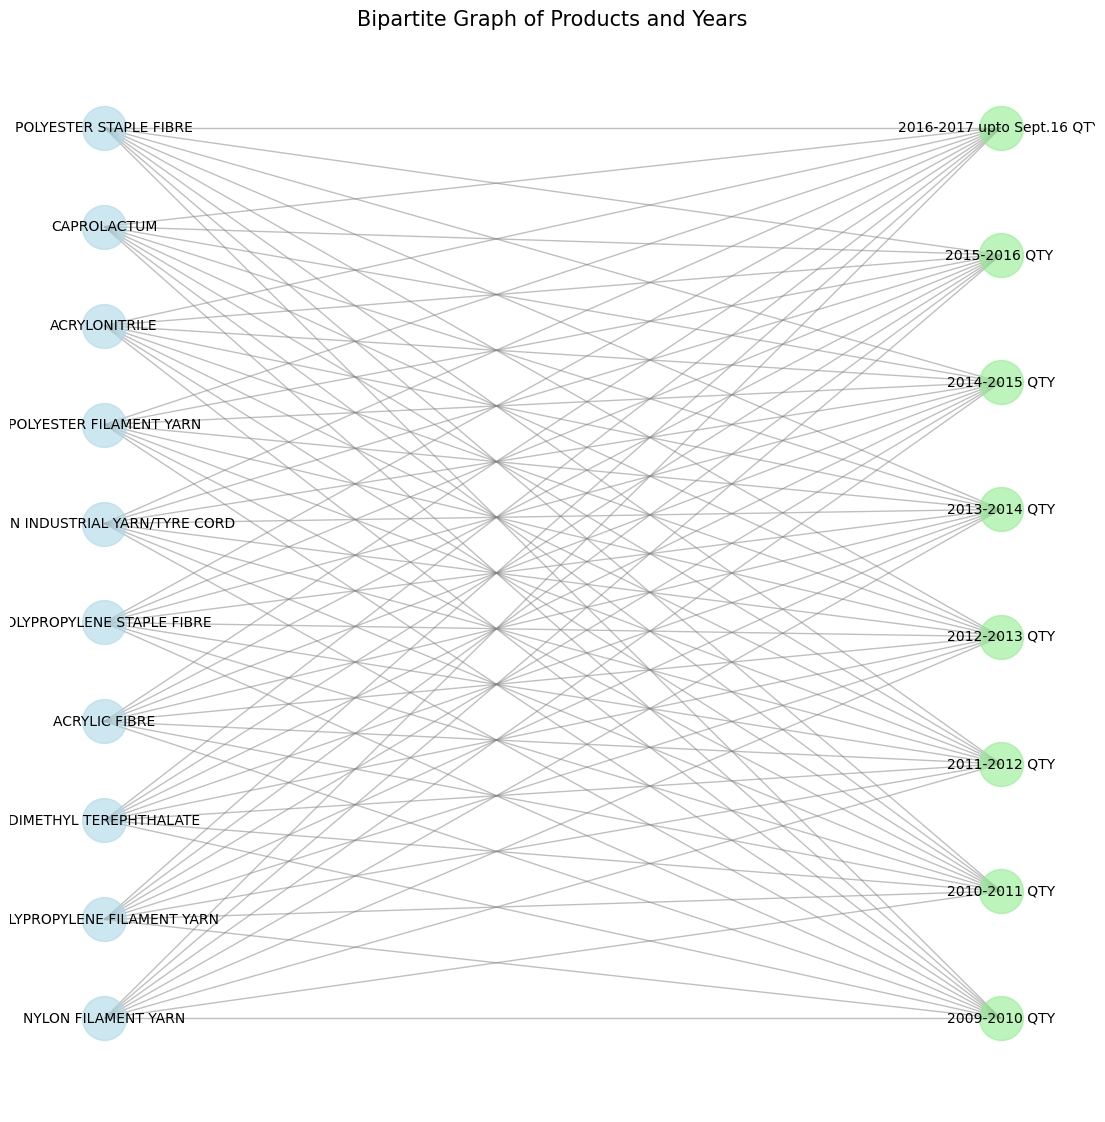

In [32]:
# Assuming G_bipartite is already created and contains the product-year data

# Identify sets of nodes
products = set(n for n, d in G_bipartite.nodes(data=True) if d['bipartite']==0)
years = set(G_bipartite) - products

# Use a bipartite layout for positioning
pos = nx.bipartite_layout(G_bipartite, products)

# Draw the graph
plt.figure(figsize=(14, 14))
# Draw product and year nodes with different colors
nx.draw_networkx_nodes(G_bipartite, pos, nodelist=products, node_color='lightblue', node_size=1000, alpha=0.6)
nx.draw_networkx_nodes(G_bipartite, pos, nodelist=years, node_color='lightgreen', node_size=1000, alpha=0.6)
nx.draw_networkx_edges(G_bipartite, pos, alpha=0.5, edge_color="grey")
nx.draw_networkx_labels(G_bipartite, pos, font_size=10)
plt.title("Bipartite Graph of Products and Years", size=15)
plt.axis('off')
plt.show()


In [33]:
# To implement the analysis for the full data across all available years, we'll first adjust the aggregation to include all years.
# This code snippet assumes 'data' is already loaded and contains the necessary columns.

# Extend the aggregation to cover all quantity and value columns dynamically
qty_columns = [col for col in data.columns if 'QTY' in col]
val_columns = [col for col in data.columns if 'VAL' in col]

# Define the aggregation dictionary dynamically
agg_dict = {col: 'mean' for col in qty_columns + val_columns}

# Assuming 'partition' is your dictionary of node-community assignments from the Louvain method
import pandas as pd

# Convert partition dictionary to a DataFrame for easier analysis
community_df = pd.DataFrame(partition.items(), columns=['Product', 'Community'])

# Count the number of products in each community
community_counts = community_df['Community'].value_counts()
print("Number of products in each community:")
print(community_counts)

# Merge community information back to the original data for further analysis
data_with_community = pd.merge(data, community_df, left_on='PRODUCT', right_on='Product')

# Analyze mean quantity and value for each community for all years
community_stats = data_with_community.groupby('Community').agg(agg_dict).reset_index()

# Convert the community_stats DataFrame to an HTML table
html_table = community_stats.to_html(index=False)

# Display the HTML table in a Jupyter notebook
from IPython.display import display, HTML
display(HTML(html_table))




Number of products in each community:
Community
1    7
0    3
Name: count, dtype: int64


Community,2009-2010 QTY,2010-2011 QTY,2011-2012 QTY,2012-2013 QTY,2013-2014 QTY,2014-2015 QTY,2015-2016 QTY,2016-2017 upto Sept.16 QTY,2009-2010 VAL,2010-2011 VAL,2011-2012 VAL,2012-2013 VAL,2013-2014 VAL,2014-2015 VAL,2015-2016 VAL|,2016-2017 upto Sept.16 VAL
0,26718.666667,27793.333333,28517.666667,33328.333333,42047.333333,43919.333333,68998.333333,35774.666667,17647.666667,28101.333333,29618.666667,35661.333333,49135.000000,54707.0,56130.333333,26347.666667
1,13980.000000,17267.142857,20356.571429,20992.857143,22121.142857,31932.714286,35361.000000,19320.428571,13946.428571,20583.857143,25962.142857,30249.714286,33186.142857,41366.0,39659.714286,20196.000000


In [50]:
import pandas as pd
import networkx as nx
import community as community_louvain


# Clean up column names by stripping extra whitespace
data.columns = data.columns.str.strip()

# Define a threshold for value significance
value_threshold = 10000  # Adjust this threshold as needed

# Initialize dictionary to store community detection results for each year
community_evolution = {}

# Get the list of years from the data columns
# Assuming the years are every other column starting with the third column
years = data.columns[2::2]  # Get every other column starting with the third

# Process data and construct graph for each year
for year_col in years:
    # Strip year column name to handle any extra spaces
    year = year_col.strip()
    
    # Create graph for the year
    G_year = nx.Graph()
    
    # Add nodes to the graph. Each node represents a product.
    for product in data['PRODUCT']:
        G_year.add_node(product)
    
    # Add edges to the graph based on the value threshold
    # Use iterrows() to iterate over DataFrame rows as (index, Series) pairs
    for i, row in data.iterrows():
        for j, inner_row in data.iterrows():
            if i < j:  # Avoid self-loops and duplicate edges
                # Access the value for both products
                value_i = row[year_col]  # Adjust if your data has different naming conventions
                value_j = inner_row[year_col]
                
                # Check if the combined value exceeds the threshold
                if (value_i + value_j) > value_threshold:
                    # Add an edge with the combined value as the weight
                    G_year.add_edge(row['PRODUCT'], inner_row['PRODUCT'], weight=value_i + value_j)
    
    # Perform community detection on the graph
    partition = community_louvain.best_partition(G_year)
    community_evolution[year] = partition




In [42]:
# Display the number of communities and the products in each community for each year
for year, communities in community_evolution.items():
    print(f"Year: {year}")
    # Convert the community assignments to a DataFrame for easier viewing
    community_df = pd.DataFrame(list(communities.items()), columns=['Product', 'Community'])
    # Display the size of each community
    community_sizes = community_df['Community'].value_counts()
    print("Community sizes:")
    print(community_sizes)
    # Display the products in each community
    for community in community_sizes.index:
        print(f"\nProducts in community {community}:")
        products_in_community = community_df[community_df['Community'] == community]['Product'].tolist()
        print(products_in_community)
    print("\n" + "-" * 80 + "\n")




Year: 2009-2010 QTY
Community sizes:
Community
0    10
Name: count, dtype: int64

Products in community 0:
['ACRYLIC FIBRE', 'NYLON FILAMENT YARN', 'NYLON INDUSTRIAL YARN/TYRE CORD', 'POLYESTER FILAMENT YARN', 'POLYESTER STAPLE FIBRE', 'POLYPROPYLENE FILAMENT YARN', 'POLYPROPYLENE STAPLE FIBRE', 'ACRYLONITRILE', 'CAPROLACTUM', 'DIMETHYL TEREPHTHALATE']

--------------------------------------------------------------------------------

Year: 2010-2011 QTY
Community sizes:
Community
0    10
Name: count, dtype: int64

Products in community 0:
['ACRYLIC FIBRE', 'NYLON FILAMENT YARN', 'NYLON INDUSTRIAL YARN/TYRE CORD', 'POLYESTER FILAMENT YARN', 'POLYESTER STAPLE FIBRE', 'POLYPROPYLENE FILAMENT YARN', 'POLYPROPYLENE STAPLE FIBRE', 'ACRYLONITRILE', 'CAPROLACTUM', 'DIMETHYL TEREPHTHALATE']

--------------------------------------------------------------------------------

Year: 2011-2012 QTY
Community sizes:
Community
0    10
Name: count, dtype: int64

Products in community 0:
['ACRYLIC FIBRE',

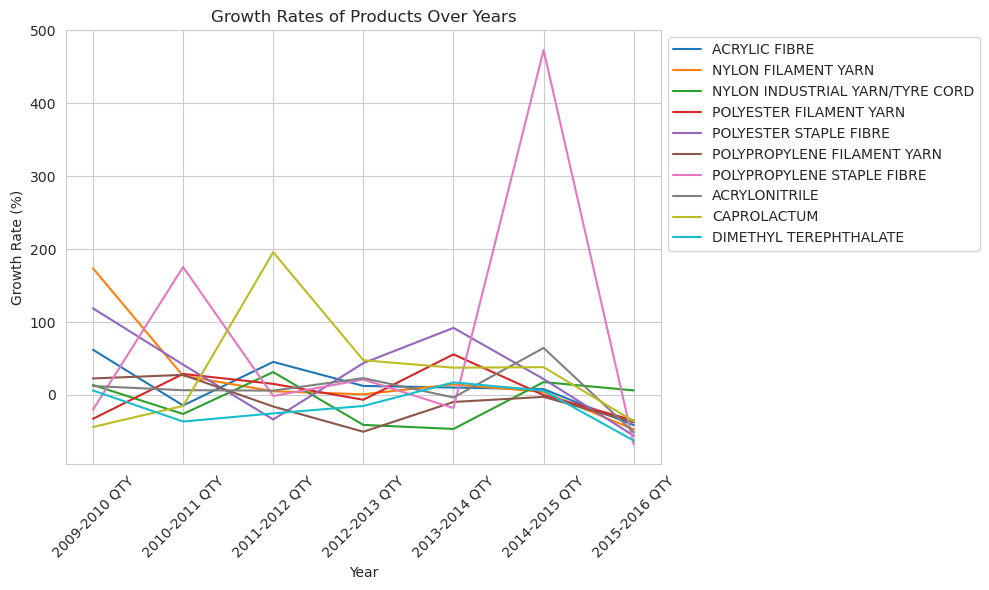

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert 'years' list to a NumPy array
years_array = np.array(years)

# Initialize a dictionary to store growth rates for each product
growth_rates = {}

# Iterate through each product
for product in data['PRODUCT'].unique():
    # Extract the data for the current product
    product_data = data[data['PRODUCT'] == product]
    
    # Initialize a list to store growth rates for the current product
    product_growth = []
    
    # Iterate through each year (except the last year)
    for i in range(len(years) - 1):
        # Calculate growth rate between consecutive years for the current product
        growth = ((product_data[years_array[i+1]] - product_data[years_array[i]]) / product_data[years_array[i]]) * 100
        product_growth.append(growth.values[0])  # Append growth rate to the list
    
    # Store the growth rates for the current product in the dictionary
    growth_rates[product] = product_growth

# Plot growth rates for all products
plt.figure(figsize=(10, 6))

for product, rates in growth_rates.items():
    plt.plot(years_array[:-1], rates, label=product)

plt.title('Growth Rates of Products Over Years')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
